In [117]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from typing import Tuple, List


In [118]:
class Vortex: 
    def __init__(self, gamma: float, center_x: float, center_y: float):
        self.gamma = gamma
        self.center_x = center_x
        self.center_y = center_y

    def get_polar(self, center_x: float, center_y: float, coord_x: int, coord_y: int) -> Tuple[float, float]:
        r = np.sqrt((coord_x - center_x)**2 + (coord_y - center_y)**2)
        theta = np.arctan2((coord_y - center_y), (coord_x - center_x))
        return (r, theta)

    def apply_phantom_vortex(self, coord_x: int, coord_y: int, copy_x: int, copy_y: int) -> Tuple[float, float]:
        phantom_gamma = -self.gamma
        phantom_r, phantom_theta = self.get_polar(copy_x, copy_y, coord_x, coord_y)
        u_theta_x = 0
        u_theta_y = 0
        if 0 < phantom_r and phantom_r < 25:
            u_theta = phantom_gamma/(2*np.pi*phantom_r)
            u_theta_x = -u_theta*np.sin(phantom_theta)
            u_theta_y = u_theta*np.cos(phantom_theta)
        
        return (u_theta_x, u_theta_y)


    def generate_vectorfield(self, x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # GIVEN a vectorfield, generate the change in the vectorfield caused by this vortex
        U_matrix = np.zeros_like(x)
        V_matrix = np.zeros_like(y)
        for i in range(len(x)):
            for j in range(len(x[i])):
                r, theta = self.get_polar(self.center_x, self.center_y, x[i][j], y[i][j])
                u_theta_x = 0.0
                u_theta_y = 0.0
                if 0 < r and r < 25:
                    u_theta = self.gamma/(2*np.pi*r)
                    u_theta_x = -u_theta*np.sin(theta)
                    u_theta_y = u_theta*np.cos(theta)

                if i < 25:
                    u_theta_x_p, u_theta_y_p = self.apply_phantom_vortex(i, j, -self.center_x, self.center_y)
                    u_theta_x += u_theta_x_p
                    u_theta_y += u_theta_y_p
                if i > len(x) - 26:
                    u_theta_x_p, u_theta_y_p = self.apply_phantom_vortex(i, j, 2 * len(x) - self.center_x, self.center_y)
                    u_theta_x += u_theta_x_p
                    u_theta_y += u_theta_y_p
                if j < 25:
                    u_theta_x_p, u_theta_y_p = self.apply_phantom_vortex(i, j, self.center_x, -self.center_y)
                    u_theta_x += u_theta_x_p
                    u_theta_y += u_theta_y_p
                if j > len(y[i]) - 26:
                    u_theta_x_p, u_theta_y_p = self.apply_phantom_vortex(i, j, self.center_x, 2 * len(y[i]) - self.center_y)
                    u_theta_x += u_theta_x_p
                    u_theta_y += u_theta_y_p

                U_matrix[i][j] = u_theta_x
                V_matrix[i][j] = u_theta_y
        return (U_matrix, V_matrix)

class Field:
    def __init__(self, x_dim: int, y_dim: int, vortices: List[Vortex]):
        self.vortices = vortices
        self.x, self.y = np.mgrid[:x_dim, :y_dim]

    def move_timestep(self, dt: float):
        print(self.x)
        # 1. Calculate vectorfields of all vortices
        U_matrix = np.zeros_like(self.x, dtype=float)
        V_matrix = np.zeros_like(self.y, dtype=float)
        for vort in self.vortices:
            X, Y = vort.generate_vectorfield(self.x, self.y)
            # 2. Sum them up on the overall vectorfield
            U_matrix += (X * dt)
            V_matrix += (Y * dt)

        # 3. Move the vortices
        for i in range(len(self.vortices)):
            closest_i = int(round(self.vortices[i].center_x))
            closest_j = int(round(self.vortices[i].center_y))
            self.vortices[i].center_x += U_matrix[closest_i][closest_j]
            self.vortices[i].center_y += V_matrix[closest_i][closest_j]


In [119]:
vortex1 = Vortex(1, 2 , 2)
field = Field(5, 5, [vortex1])

for i in range(200):
    field.move_timestep(0.1)

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 

/Users/maddykovaleski/miniforge3/envs/math_env/lib/python3.8/site-packages/matplotlib/animation.py:880: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


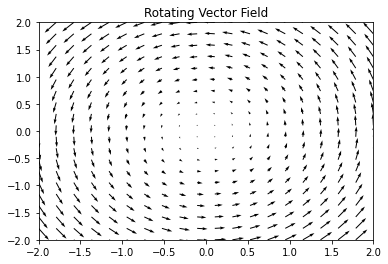

In [120]:
# Set up the grid for the vector field
x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title("Rotating Vector Field")

# Initialize the vector field
U = -Y
V = X
quiver = ax.quiver(X, Y, U, V)

# Animation function to update U and V at each frame
def animate(frame):
    # Define rotation angle
    angle = frame * 0.2  # Controls the speed of rotation

    # Rotate the vector field by updating U and V based on `angle`
    U = -Y * np.cos(angle) - X * np.sin(angle)
    V = X * np.cos(angle) - Y * np.sin(angle)

    # Update the vector field in the quiver plot
    quiver.set_UVC(U, V)
    return quiver,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=100, interval=5, blit=False)

plt.show()
